In [1]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage
from mne import Epochs, EvokedArray, create_info, io, pick_types, read_events
from mne.datasets import sample
from mne.decoding import Vectorizer
from mne.decoding import CSP

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import torchaudio

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import pickle 


/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, spectral_analysis, training

In [3]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/spectral_analysis.py'>

## Check Loading of Braccio Dataset Files

Number of channels:  64
Number of samples:  64


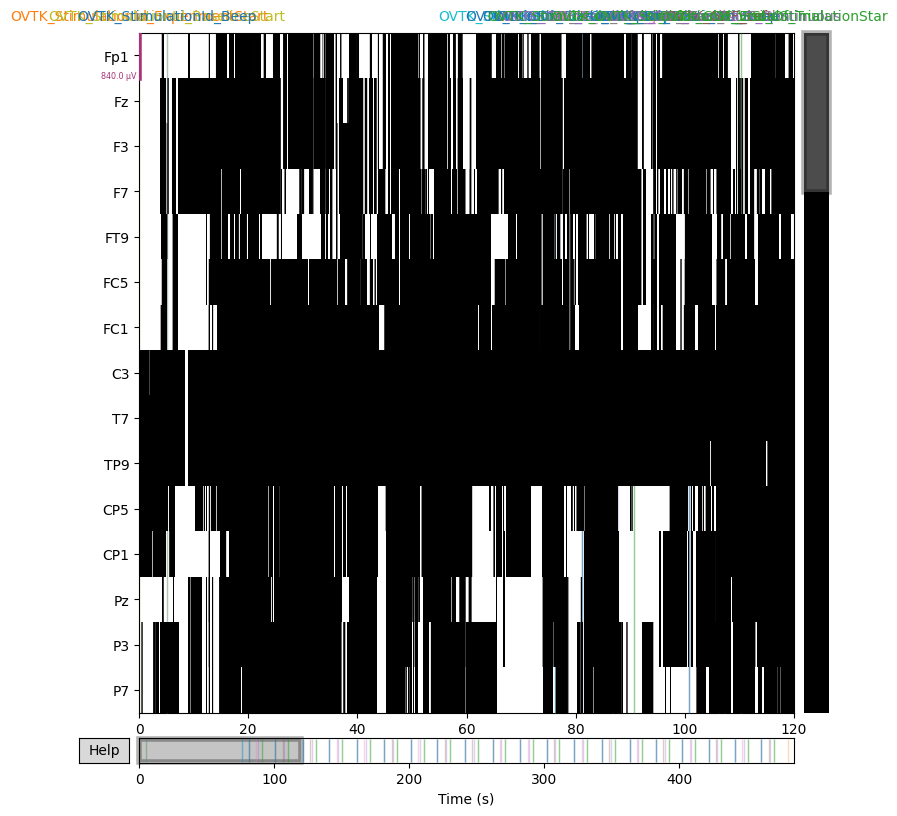

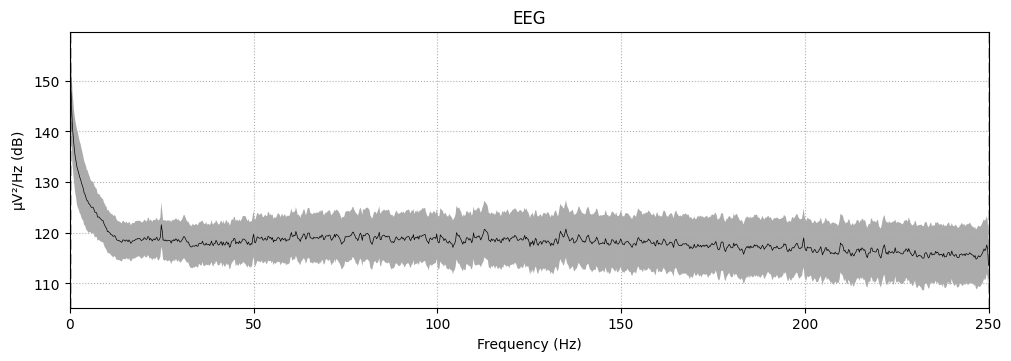

In [2]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

## Intra-Subject Classification

In [5]:
# Define the subject and the session
task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"

num_sessions = [1,2,3]
num_subjects = [1,2,3,5,6,7,8,10,11,13,14]   
list_labels = ['OVTK_GDF_Left','OVTK_GDF_Right']

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_idx_channels = [list_all_ch_names.index(ch) for ch in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

# Define the parameters of the dataset
feature_type = ["time"]
dict_preprocessing = {"polynomial_degree":None,"tmin":0,"tmax":4,"seq_length":2001}
dict_features = {"type_psd":"welch","fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}

num_subject = num_subjects[4]
num_val_subjects = [num_subject]
num_test_subjects = [num_subject]
num_train_subjects = [num_subject]
num_train_sessions = [1]
num_val_sessions = [2]
num_test_sessions = [3]

print("Train subjects: ", num_train_subjects)
print("Val subjects: ", num_val_subjects)
print("Test subjects: ", num_test_subjects)

# Create the dataset
trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_train_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)
testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_test_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)
valset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_val_subjects, num_val_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)

# Create the dataloader
trainset.transform_dataset_numpy_to_torch()
trainset.features["time"] = trainset.features["time"].unsqueeze(1)
testset.transform_dataset_numpy_to_torch()
testset.features["time"] = testset.features["time"].unsqueeze(1)
valset.transform_dataset_numpy_to_torch()
valset.features["time"] = valset.features["time"].unsqueeze(1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True, num_workers=2)

feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=2001,
            num_electrodes=12,
            dropout=0,
            kernel_1=500,
            kernel_2=250,
            F1=4,
            F2=16,
            D=2,
            num_classes=2)
model.to(device)
model.load_state_dict(torch.load("../models/EEGNet/EEGNet_Subject_{}.pt".format(num_subject)))
for param in model.named_parameters():
    if "lin" in param[0]:
        continue
    else:
        param[1].requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler_dict = {"MultiplicativeLR" : scheduler}
logs = training.train_model(model, trainloader, valloader, device, criterion, feature_type, 51, optimizer, scheduler_dict, print_epoch = 5)
# change weights of the model to the best weights
model.load_state_dict(logs["best_model_weights"])
model.eval()
train_balanced_accuracy, train_loss = training.evaluate_classification_model(model,trainloader,device,criterion,feature_type,dataset="Train")
val_balanced_accuracy, val_loss = training.evaluate_classification_model(model,valloader,device,criterion,feature_type,dataset="Val")
test_balanced_accuracy, test_loss = training.evaluate_classification_model(model,testloader,device,criterion,feature_type,dataset="Test")

        


Train subjects:  [6]
Val subjects:  [6]
Test subjects:  [6]
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


Epoch 0:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 0
lr:  0.01
-------------------------
Train set: Avg. loss: 0.0394, Balanced Accuracy: 0.6687500476837158 (67%)
Test set: Avg. loss: 0.0172, Balanced Accuracy: 0.7687499523162842 (77%)
Saving best model weights with balanced accuracy:  0.7687499523162842
-------------------------


Epoch 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 5
lr:  0.007737809374999999
-------------------------
Train set: Avg. loss: 0.0127, Balanced Accuracy: 0.9312499761581421 (93%)
Test set: Avg. loss: 0.0204, Balanced Accuracy: 0.75 (75%)
-------------------------


Epoch 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 10
lr:  0.005987369392383786
-------------------------
Train set: Avg. loss: 0.0071, Balanced Accuracy: 0.9937499761581421 (99%)
Test set: Avg. loss: 0.0236, Balanced Accuracy: 0.7749999761581421 (77%)
Saving best model weights with balanced accuracy:  0.7749999761581421
-------------------------


Epoch 15:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 15
lr:  0.00463291230159753
-------------------------
Train set: Avg. loss: 0.0041, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0267, Balanced Accuracy: 0.7749999761581421 (77%)
-------------------------


Epoch 20:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0035848592240854188
-------------------------
Train set: Avg. loss: 0.0026, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0297, Balanced Accuracy: 0.7562500238418579 (76%)
-------------------------


Epoch 25:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 25
lr:  0.0027738957312183374
-------------------------
Train set: Avg. loss: 0.0019, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0316, Balanced Accuracy: 0.7562500238418579 (76%)
-------------------------


Epoch 30:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 30
lr:  0.0021463876394293723
-------------------------
Train set: Avg. loss: 0.0015, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0341, Balanced Accuracy: 0.7437499761581421 (74%)
-------------------------


Epoch 35:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 35
lr:  0.0016608338398760713
-------------------------
Train set: Avg. loss: 0.0013, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0350, Balanced Accuracy: 0.75 (75%)
-------------------------


Epoch 40:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 40
lr:  0.0012851215656510308
-------------------------
Train set: Avg. loss: 0.0012, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0359, Balanced Accuracy: 0.7374999523162842 (74%)
-------------------------


Epoch 45:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 45
lr:  0.000994402569870922
-------------------------
Train set: Avg. loss: 0.0011, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0368, Balanced Accuracy: 0.7437499761581421 (74%)
-------------------------


Epoch 50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 50
lr:  0.0007694497527671312
-------------------------
Train set: Avg. loss: 0.0010, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0371, Balanced Accuracy: 0.7437499761581421 (74%)
-------------------------


Epoch 50: 100%|██████████| 10/10 [00:01<00:00,  6.05batch/s, accuracy=1, loss=0.00127]


Train set: Avg. loss: 0.0071, Balanced Accuracy: 0.9937499761581421 (99%)
Val set: Avg. loss: 0.0236, Balanced Accuracy: 0.7749999761581421 (77%)
Test set: Avg. loss: 0.0226, Balanced Accuracy: 0.7062499523162842 (71%)


In [6]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = EEGNet(chunk_size=2001,
            num_electrodes=12,
            dropout=0,
            kernel_1=500,
            kernel_2=250,
            F1=4,
            F2=16,
            D=2,
            num_classes=2)
model.to(device)
model.load_state_dict(torch.load("../models/EEGNet/EEGNet_Subject_{}.pt".format(num_subject)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler_dict = {"MultiplicativeLR" : scheduler}
logs = training.train_model(model, trainloader, valloader, device, criterion, feature_type, 51, optimizer, scheduler_dict, print_epoch = 5)
# change weights of the model to the best weights
model.load_state_dict(logs["best_model_weights"])
model.eval()
train_balanced_accuracy, train_loss = training.evaluate_classification_model(model,trainloader,device,criterion,feature_type,dataset="Train")
val_balanced_accuracy, val_loss = training.evaluate_classification_model(model,valloader,device,criterion,feature_type,dataset="Val")
test_balanced_accuracy, test_loss = training.evaluate_classification_model(model,testloader,device,criterion,feature_type,dataset="Test")

Epoch 0:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 0
lr:  0.01
-------------------------
Train set: Avg. loss: 0.0394, Balanced Accuracy: 0.6687500476837158 (67%)
Test set: Avg. loss: 0.0172, Balanced Accuracy: 0.7687499523162842 (77%)
Saving best model weights with balanced accuracy:  0.7687499523162842
-------------------------


Epoch 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 5
lr:  0.007737809374999999
-------------------------
Train set: Avg. loss: 0.0070, Balanced Accuracy: 0.9437500238418579 (94%)
Test set: Avg. loss: 0.0195, Balanced Accuracy: 0.8312499523162842 (83%)
Saving best model weights with balanced accuracy:  0.8312499523162842
-------------------------


Epoch 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 10
lr:  0.005987369392383786
-------------------------
Train set: Avg. loss: 0.0068, Balanced Accuracy: 0.9437500238418579 (94%)
Test set: Avg. loss: 0.0275, Balanced Accuracy: 0.7875000238418579 (79%)
-------------------------


Epoch 15:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 15
lr:  0.00463291230159753
-------------------------
Train set: Avg. loss: 0.0007, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0284, Balanced Accuracy: 0.7937500476837158 (79%)
-------------------------


Epoch 20:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0035848592240854188
-------------------------
Train set: Avg. loss: 0.0010, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0273, Balanced Accuracy: 0.8125 (81%)
-------------------------


Epoch 25:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 25
lr:  0.0027738957312183374
-------------------------
Train set: Avg. loss: 0.0002, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0319, Balanced Accuracy: 0.800000011920929 (80%)
-------------------------


Epoch 30:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 30
lr:  0.0021463876394293723
-------------------------
Train set: Avg. loss: 0.0001, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0331, Balanced Accuracy: 0.8125 (81%)
-------------------------


Epoch 35:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 35
lr:  0.0016608338398760713
-------------------------
Train set: Avg. loss: 0.0001, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0337, Balanced Accuracy: 0.8125 (81%)
-------------------------


Epoch 40:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 40
lr:  0.0012851215656510308
-------------------------
Train set: Avg. loss: 0.0001, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0347, Balanced Accuracy: 0.8062499761581421 (81%)
-------------------------


Epoch 45:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 45
lr:  0.000994402569870922
-------------------------
Train set: Avg. loss: 0.0001, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0349, Balanced Accuracy: 0.8062499761581421 (81%)
-------------------------


Epoch 50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 50
lr:  0.0007694497527671312
-------------------------
Train set: Avg. loss: 0.0001, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0354, Balanced Accuracy: 0.8187500238418579 (82%)
-------------------------


Epoch 50: 100%|██████████| 10/10 [00:01<00:00,  5.29batch/s, accuracy=1, loss=0.000125]


Train set: Avg. loss: 0.0070, Balanced Accuracy: 0.9437500238418579 (94%)
Val set: Avg. loss: 0.0195, Balanced Accuracy: 0.8312499523162842 (83%)
Test set: Avg. loss: 0.0184, Balanced Accuracy: 0.8125 (81%)


torch.Size([4, 1, 1, 500])


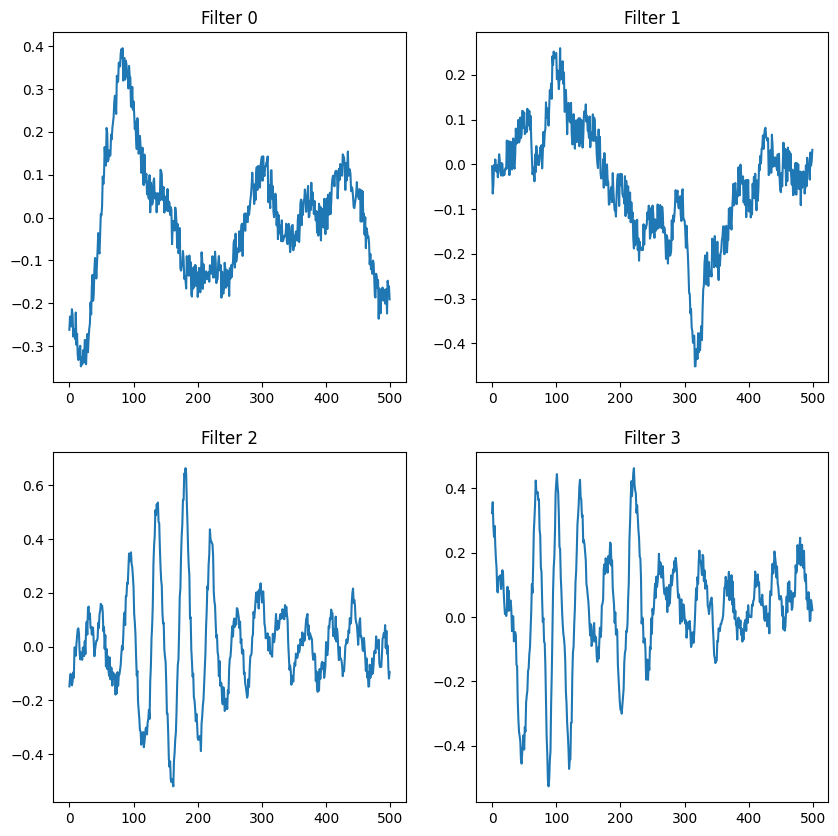

In [7]:
for param in model.parameters():
    print(param.data.shape)
    time_filters = param.data.cpu().numpy()
    break

# plot all the filters
fig, axs = plt.subplots(2,2,figsize=(10,10))
for i in range(4):
    ax = axs[i//2,i%2]
    ax.plot(time_filters[i,0,0,:])
    ax.set_title("Filter "+str(i))
plt.savefig("../plots/intra_subject_classification_transfer/time_filters_eegnet_sessions.png")
plt.show()

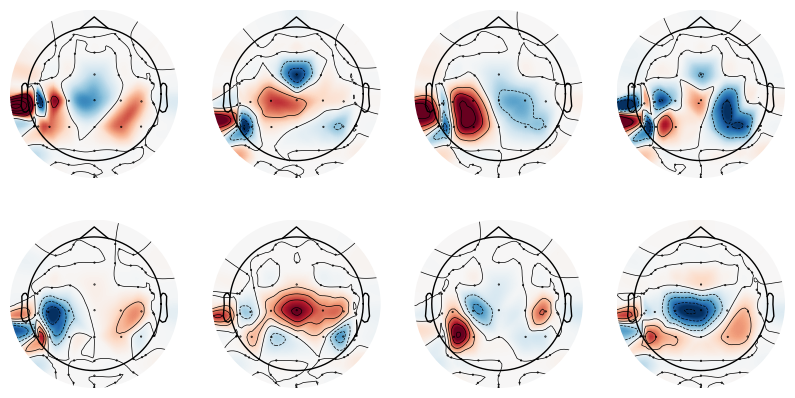

In [8]:
montage = mne.channels.make_standard_montage('standard_1020')
list_channels_std = list_all_ch_names

def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[channel])
    return np.array(positions)

ch_positions = get_positions_from_channel_list(list_channels_std, montage)

fig, ax = plt.subplots(2, 4, figsize=(10, 5))

for i in range(2):
    for j in range(4):
        spatial_map_12 = model.block1[2].weight.data[i + 2 * j].cpu().numpy().flatten()
        spatial_map_64 = np.zeros(64)
        spatial_map_64[list_idx_channels] = spatial_map_12
        mne.viz.plot_topomap(
            spatial_map_64,
            ch_positions[:, :2],
            show=False,
            axes=ax[i, j]
        )
plt.savefig("../plots/intra_subject_classification_transfer/spatial_filters_eegnet_sessions.png")
plt.show()

## ATCNet

In [21]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)

<module 'eeg_project_package.models' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/models.py'>

In [9]:

# Define the subject and the session
task_type = "imaginary_left/right"
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/"

num_sessions = [1,2,3]
num_subjects = [1,2,3,5,6,7,8,10,11,13,14]   
list_labels = ['OVTK_GDF_Left','OVTK_GDF_Right']

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_idx_channels = [list_all_ch_names.index(ch) for ch in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

# Define the parameters of the dataset
feature_type = ["time"]
dict_preprocessing = {"polynomial_degree":None,"tmin":0,"tmax":4,"seq_length":2001}
dict_features = {"type_psd":"welch","fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}

num_subject = num_subjects[4]
num_val_subjects = [num_subject]
num_test_subjects = [num_subject]
num_train_subjects = [num_subject]
num_train_sessions = [1]
num_val_sessions = [2]
num_test_sessions = [3]

print("Train subjects: ", num_train_subjects)
print("Val subjects: ", num_val_subjects)
print("Test subjects: ", num_test_subjects)

# Create the dataset
trainset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_train_subjects, num_train_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)
testset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_test_subjects, num_test_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)
valset = dataset.Braccio_Dataset_Multi_Subject(folder_path, num_val_subjects, num_val_sessions, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = feature_type, dict_preprocessing = dict_preprocessing, dict_features = dict_features)

# Create the dataloader
trainset.transform_dataset_numpy_to_torch()
trainset.features["time"] = trainset.features["time"].unsqueeze(1)
testset.transform_dataset_numpy_to_torch()
testset.features["time"] = testset.features["time"].unsqueeze(1)
valset.transform_dataset_numpy_to_torch()
valset.features["time"] = valset.features["time"].unsqueeze(1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True, num_workers=2)

feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.ATCNet(in_channels=1,
            num_classes=2,
            num_windows=5,
            num_electrodes=12,
            chunk_size=2001,
            filter_size=250,)
model.to(device)
model.load_state_dict(torch.load("../models/ATCNet/ATCNet_Subject_{}.pt".format(num_subjects[i])))
for param in model.named_parameters():
    if "dense4" in param[0]:
        continue
    else:
        param[1].requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1} #, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, valloader, device, criterion, feature_type, 51, optimizer, scheduler_dict, print_epoch = 5)
# change weights of the model to the best weights
model.load_state_dict(logs["best_model_weights"])
model.eval()
train_balanced_accuracy, train_loss = training.evaluate_classification_model(model,trainloader,device,criterion,feature_type,dataset="Train")
val_balanced_accuracy, val_loss = training.evaluate_classification_model(model,valloader,device,criterion,feature_type,dataset="Val")
test_balanced_accuracy, test_loss = training.evaluate_classification_model(model,testloader,device,criterion,feature_type,dataset="Test")

        

Train subjects:  [6]
Val subjects:  [6]
Test subjects:  [6]
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationId_ExperimentStart, OVTK_StimulationId_BaselineStart/OVTK_StimulationId_Beep'


/home/aurelien.stumpf/Development/BCI_Classification/eeg_env/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 0:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 0
lr:  0.001
-------------------------
Train set: Avg. loss: 0.0297, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0126, Balanced Accuracy: 0.9125000238418579 (91%)
Saving best model weights with balanced accuracy:  0.9125000238418579
-------------------------


Epoch 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 5
lr:  0.0007737809374999998
-------------------------
Train set: Avg. loss: 0.0287, Balanced Accuracy: 0.8374999761581421 (84%)
Test set: Avg. loss: 0.0125, Balanced Accuracy: 0.9125000238418579 (91%)
-------------------------


Epoch 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 10
lr:  0.0005987369392383785
-------------------------
Train set: Avg. loss: 0.0288, Balanced Accuracy: 0.8374999761581421 (84%)
Test set: Avg. loss: 0.0126, Balanced Accuracy: 0.9125000238418579 (91%)
-------------------------


Epoch 15:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 15
lr:  0.00046329123015975297
-------------------------
Train set: Avg. loss: 0.0286, Balanced Accuracy: 0.8374999761581421 (84%)
Test set: Avg. loss: 0.0124, Balanced Accuracy: 0.9125000238418579 (91%)
-------------------------


Epoch 20:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0003584859224085418
-------------------------
Train set: Avg. loss: 0.0286, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0125, Balanced Accuracy: 0.9125000238418579 (91%)
-------------------------


Epoch 25:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 25
lr:  0.00027738957312183364
-------------------------
Train set: Avg. loss: 0.0285, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0124, Balanced Accuracy: 0.918749988079071 (92%)
Saving best model weights with balanced accuracy:  0.918749988079071
-------------------------


Epoch 30:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 30
lr:  0.00021463876394293716
-------------------------
Train set: Avg. loss: 0.0284, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0124, Balanced Accuracy: 0.918749988079071 (92%)
-------------------------


Epoch 35:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 35
lr:  0.00016608338398760707
-------------------------
Train set: Avg. loss: 0.0284, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0124, Balanced Accuracy: 0.918749988079071 (92%)
-------------------------


Epoch 40:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 40
lr:  0.00012851215656510304
-------------------------
Train set: Avg. loss: 0.0284, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0123, Balanced Accuracy: 0.918749988079071 (92%)
-------------------------


Epoch 45:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 45
lr:  9.944025698709218e-05
-------------------------
Train set: Avg. loss: 0.0284, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0123, Balanced Accuracy: 0.918749988079071 (92%)
-------------------------


Epoch 50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 50
lr:  7.69449752767131e-05
-------------------------
Train set: Avg. loss: 0.0284, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0123, Balanced Accuracy: 0.918749988079071 (92%)
-------------------------


Epoch 50: 100%|██████████| 10/10 [00:01<00:00,  6.71batch/s, accuracy=0.831, loss=0.0297]


Train set: Avg. loss: 0.0285, Balanced Accuracy: 0.84375 (84%)
Val set: Avg. loss: 0.0124, Balanced Accuracy: 0.918749988079071 (92%)
Test set: Avg. loss: 0.0135, Balanced Accuracy: 0.8562500476837158 (86%)


In [10]:
feature_type = "time"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()
model = models.ATCNet(in_channels=1,
            num_classes=2,
            num_windows=5,
            num_electrodes=12,
            chunk_size=2001,
            filter_size=250,)
model.to(device)
model.load_state_dict(torch.load("../models/ATCNet/ATCNet_Subject_{}.pt".format(num_subjects[i])))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.95)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
scheduler_dict = {"MultiplicativeLR":scheduler1} #, "ReduceLROnPlateau":scheduler2}
logs = training.train_model(model, trainloader, valloader, device, criterion, feature_type, 51, optimizer, scheduler_dict, print_epoch = 5)
# change weights of the model to the best weights
model.load_state_dict(logs["best_model_weights"])
model.eval()
train_balanced_accuracy, train_loss = training.evaluate_classification_model(model,trainloader,device,criterion,feature_type,dataset="Train")
val_balanced_accuracy, val_loss = training.evaluate_classification_model(model,valloader,device,criterion,feature_type,dataset="Val")
test_balanced_accuracy, test_loss = training.evaluate_classification_model(model,testloader,device,criterion,feature_type,dataset="Test")

Epoch 0:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 0
lr:  0.001
-------------------------
Train set: Avg. loss: 0.0297, Balanced Accuracy: 0.84375 (84%)
Test set: Avg. loss: 0.0126, Balanced Accuracy: 0.9125000238418579 (91%)
Saving best model weights with balanced accuracy:  0.9125000238418579
-------------------------


Epoch 5:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 5
lr:  0.0007737809374999998
-------------------------
Train set: Avg. loss: 0.0224, Balanced Accuracy: 0.9562499523162842 (96%)
Test set: Avg. loss: 0.0131, Balanced Accuracy: 0.8999999761581421 (90%)
-------------------------


Epoch 10:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 10
lr:  0.0005987369392383785
-------------------------
Train set: Avg. loss: 0.0205, Balanced Accuracy: 0.9937499761581421 (99%)
Test set: Avg. loss: 0.0135, Balanced Accuracy: 0.887499988079071 (89%)
-------------------------


Epoch 15:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 15
lr:  0.00046329123015975297
-------------------------
Train set: Avg. loss: 0.0201, Balanced Accuracy: 0.9937499761581421 (99%)
Test set: Avg. loss: 0.0139, Balanced Accuracy: 0.8624999523162842 (86%)
-------------------------


Epoch 20:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 20
lr:  0.0003584859224085418
-------------------------
Train set: Avg. loss: 0.0199, Balanced Accuracy: 0.9937499761581421 (99%)
Test set: Avg. loss: 0.0137, Balanced Accuracy: 0.8812500238418579 (88%)
-------------------------


Epoch 25:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 25
lr:  0.00027738957312183364
-------------------------
Train set: Avg. loss: 0.0197, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0138, Balanced Accuracy: 0.856249988079071 (86%)
-------------------------


Epoch 30:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 30
lr:  0.00021463876394293716
-------------------------
Train set: Avg. loss: 0.0196, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0137, Balanced Accuracy: 0.856249988079071 (86%)
-------------------------


Epoch 35:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 35
lr:  0.00016608338398760707
-------------------------
Train set: Avg. loss: 0.0196, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0136, Balanced Accuracy: 0.875 (88%)
-------------------------


Epoch 40:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 40
lr:  0.00012851215656510304
-------------------------
Train set: Avg. loss: 0.0196, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0136, Balanced Accuracy: 0.875 (88%)
-------------------------


Epoch 45:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 45
lr:  9.944025698709218e-05
-------------------------
Train set: Avg. loss: 0.0196, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0137, Balanced Accuracy: 0.862500011920929 (86%)
-------------------------


Epoch 50:   0%|          | 0/10 [00:00<?, ?batch/s]

Epoch 50
lr:  7.69449752767131e-05
-------------------------
Train set: Avg. loss: 0.0196, Balanced Accuracy: 1.0 (100%)
Test set: Avg. loss: 0.0137, Balanced Accuracy: 0.8500000238418579 (85%)
-------------------------


Epoch 50: 100%|██████████| 10/10 [00:02<00:00,  3.45batch/s, accuracy=1, loss=0.02] 


Train set: Avg. loss: 0.0297, Balanced Accuracy: 0.84375 (84%)
Val set: Avg. loss: 0.0126, Balanced Accuracy: 0.9125000238418579 (91%)
Test set: Avg. loss: 0.0135, Balanced Accuracy: 0.8812500238418579 (88%)


torch.Size([16, 1, 1, 250])


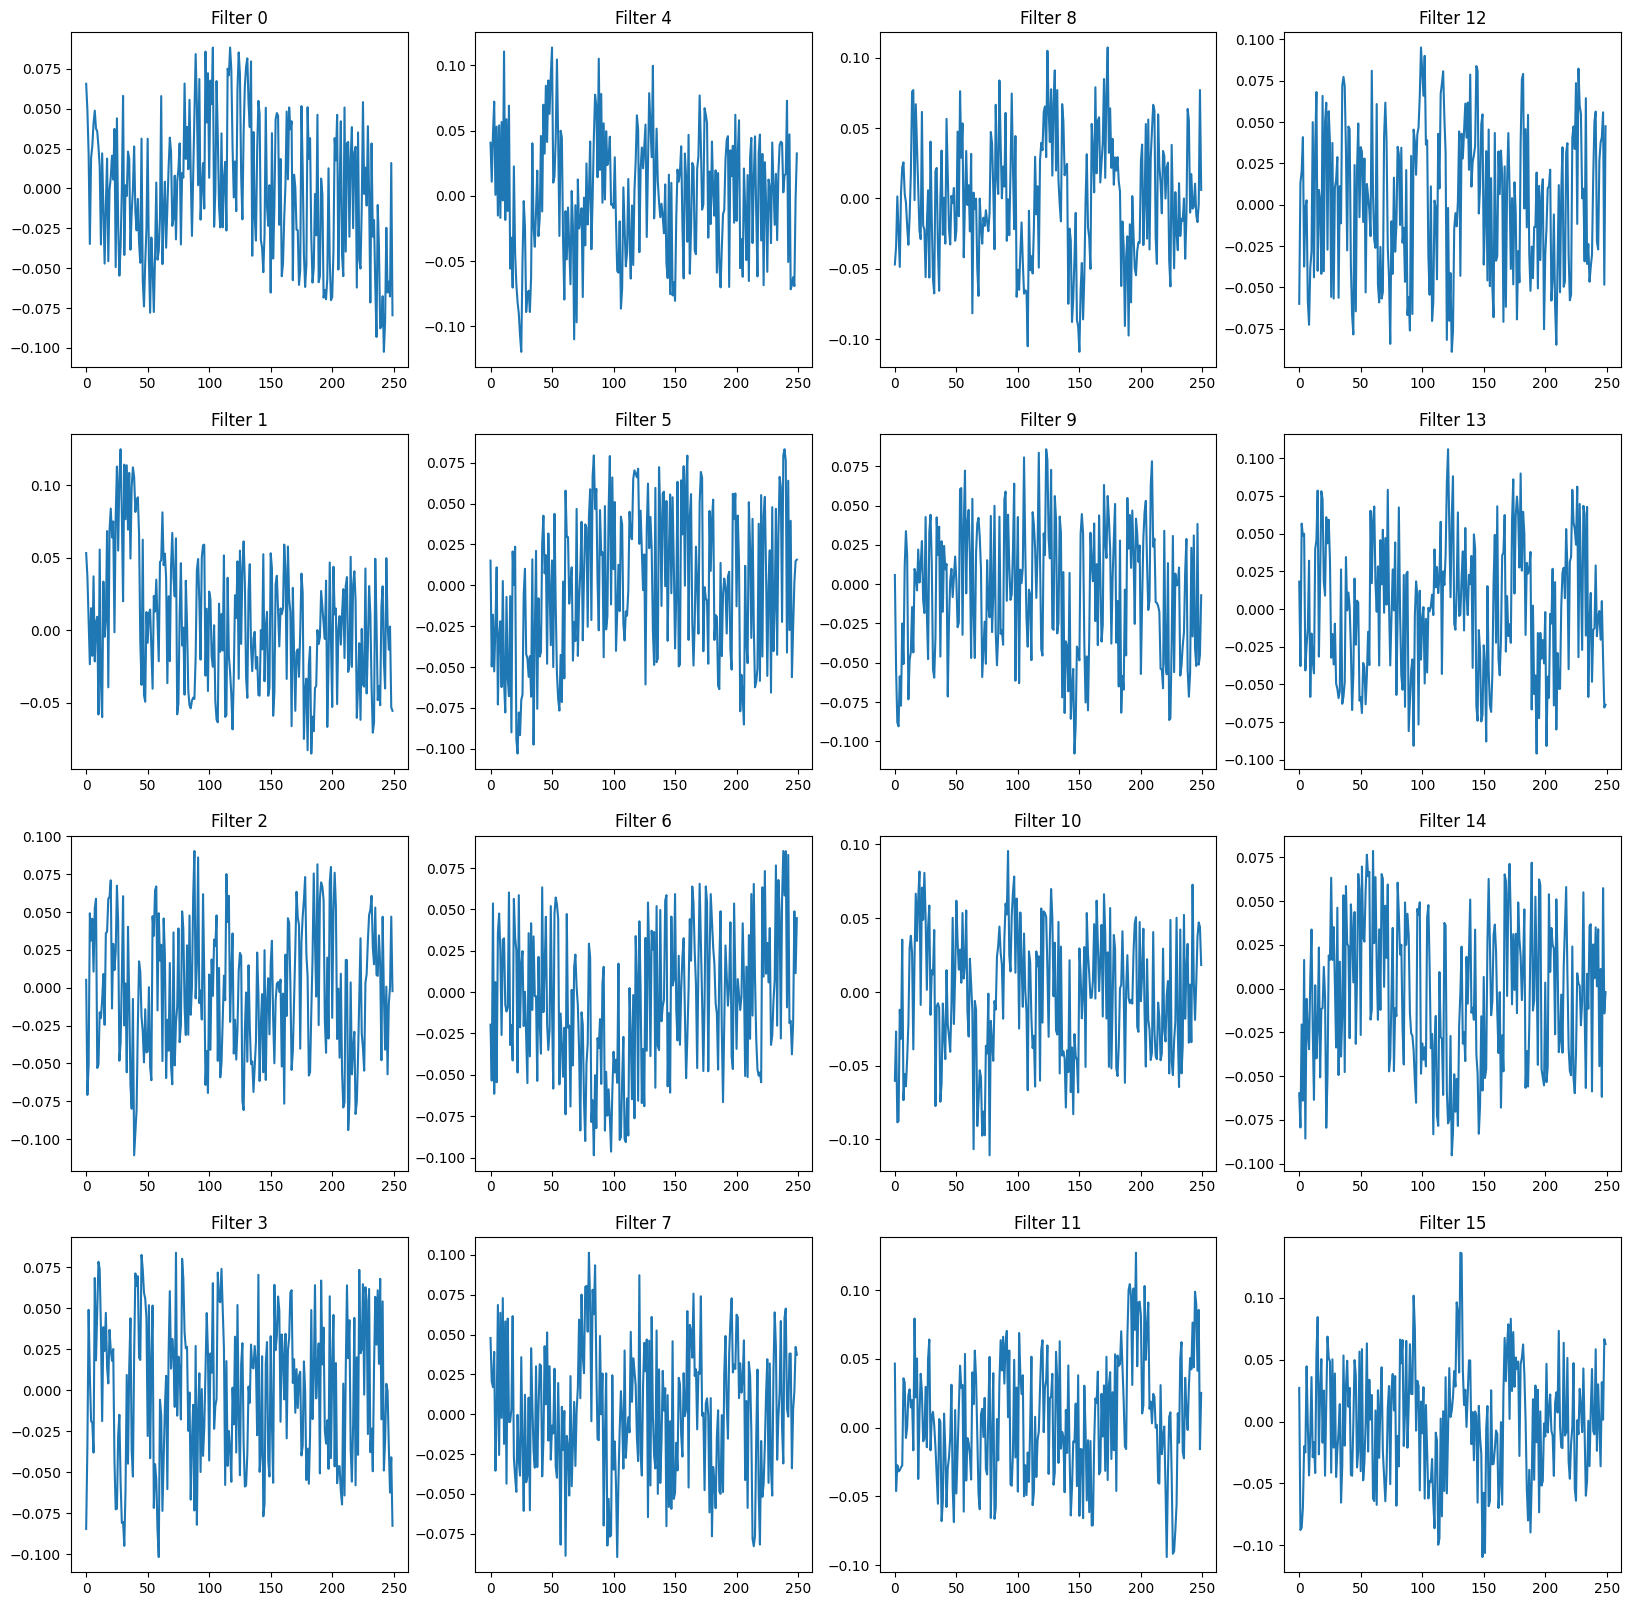

In [11]:
for param in model.parameters():
    print(param.data.shape)
    time_filters = param.data.cpu().numpy()
    break

# plot all the filters
fig, axs = plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        axs[i,j].plot(time_filters[i + 4*j,0,0,:])
        axs[i,j].set_title("Filter " + str(i + 4*j))
plt.savefig("../plots/intra_subject_classification_transfer/time_filters_atcnet_sessions.png")
plt.show()

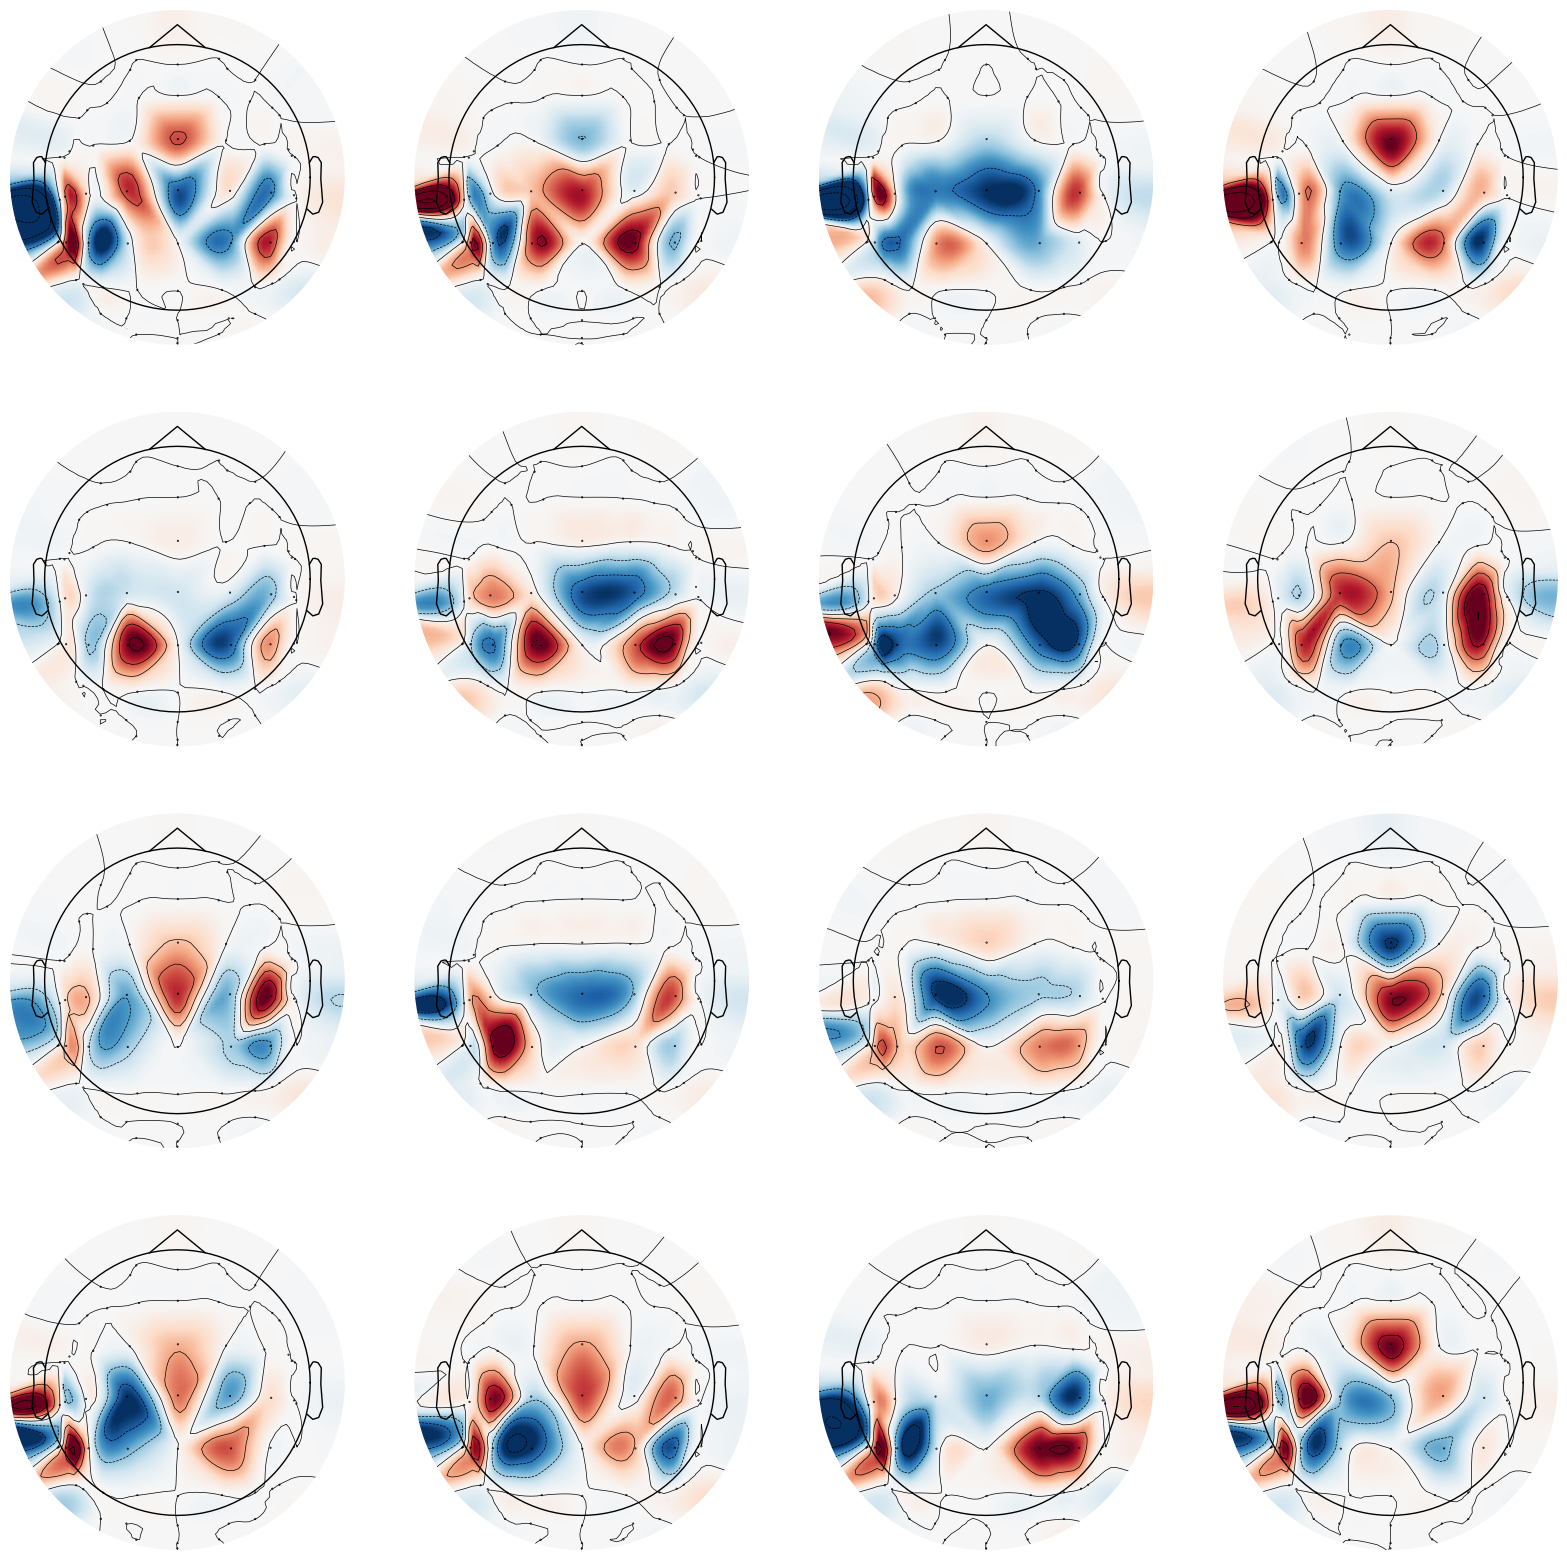

In [12]:
montage = mne.channels.make_standard_montage('standard_1020')
list_channels_std = list_all_ch_names

def get_positions_from_channel_list(channel_list, montage):
    dict_positions = montage.get_positions()["ch_pos"]
    positions = []
    for channel in channel_list:
        positions.append(dict_positions[channel])
    return np.array(positions)

ch_positions = get_positions_from_channel_list(list_channels_std, montage)

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i in range(4):
    for j in range(4):
        spatial_map_12 = model.conv_block[2].weight.data[i + 4 * j].cpu().numpy().flatten()
        spatial_map_64 = np.zeros(64)
        spatial_map_64[list_idx_channels] = spatial_map_12
        mne.viz.plot_topomap(
            spatial_map_64,
            ch_positions[:, :2],
            show=False,
            axes=ax[j, i]
        )
plt.savefig("../plots/intra_subject_classification_transfer/spatial_filters_atcnet_sessions.png")
plt.show()